# Step 2: Binary Logistic Regression
In this notebook, the binary logistic regression is done. First, necessary packages and files are imported and colours are defined, then the functions are defined. This is followed by the binary logistic regression.

## 0. Data import and preparation

### 0.1 Import packages

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import os
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [2]:
#Remove warnings
warnings.filterwarnings("ignore")

### 0.2 Read files

In [3]:
#Reading the grouped_survey file
survey_data = pd.read_csv('../datafiles/grouped_survey.csv')

### 0.3 Define colours

In [4]:
map_colours = {
    1: '#2e4a7d',
    2: '#4e6d91',
    3: '#6e8d95',
    4: '#90ac8c',
    5: '#b2ca7f',
    6: '#d6e47b',
    7: '#fee838',
    8: '#feeb33',
    9: '#f9d636',
    10: '#f4c539',
    11: '#f0b23c',
    12: '#ec9d3f',
    13: '#e78942',
    14: '#e37545',
    15: '#df6048',
    16: '#db4c4b',
    17: '#d7384e',
    18: '#d52451',
}

In [5]:
# Convert the l_colors dictionary to a list of colors for implementing in spearman correlation
colour_list = [color for key, color in sorted(map_colours.items())]

In [6]:
# Create a custom colormap from the color list
custom_cmap = LinearSegmentedColormap.from_list("custom_colors", colour_list)

### 0.4 Functions

In [7]:
def column_numeric(columns_list):
    # This function is to set object type columns to numeric, 
    # as seen in Step0Exploratory many columns have object type due to empty strings
    for column in columns_list: 
        survey_data[column] = pd.to_numeric(survey_data[column], errors='coerce')

In [8]:
def spearman_correlation_matrix(data, trust_var, columns_list, title):
    #This function creates a correlation matrix, with input the data, column list, 
    #the trust variabels and title. 

    #Extending the trust variables with the input column list
    trust_var.extend(columns_list)

    #Selecting the correlation variables in the data
    correlation_df=data[trust_var]
    
    #Perform the spearman correlation
    correlation_spearman = correlation_df.corr(method='spearman')

    #Plot the spearman correlation in a heatmap
    fig, ax = plt.subplots(figsize=(15, 10))

    #Create the heatmap based on the custom colours and setting legend min and max
    heatmap=sns.heatmap(correlation_spearman, cmap=custom_cmap, annot=True, vmin=-1, vmax=1, cbar=False, annot_kws={"size": 13})
    
    # Get current axes
    ax = plt.gca()
    
    # Creating a horizontal colorbar next to the plot
    # Get the actual image object to generate a colour bar
    im = heatmap.get_children()[0]

    #Helps to append new axes next to the existing one
    divider = make_axes_locatable(ax)
    #Sets new colour bar to the left of the original axis, 5% width
    # of the main plot and 3.9 space between main axis and colour bar
    cax = divider.append_axes("left", size="5%", pad=3.9)

    # Creating the vertical colourbar
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    #Set tick size of colour bar
    cbar.ax.tick_params(labelsize=13)
    
    # Remove axis titles
    ax.set_xlabel('')
    ax.set_ylabel('')
    #Set axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16) 
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=16) 

    #Create file path for saving the figure
    full_path = os.path.join('../figures/step2', title)
    plt.savefig(full_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    #Show plot
    plt.show()


In [9]:
def heatmap_regression(value, title, data, legend_min, legend_max, base, cutoff):
    # This function is to create heatmaps of the regression metrics, setting
    # the title of the plot, the min/max of the legend and the cut off for the 
    # colours in the heatmap (values that are e.g. not significant)
    
    #Pivoting the input dataframe for mapping
    pivot_df=data.pivot(index='x variable', columns='y variable', values=value)
    
     #Clip data to cutoff for color mapping, setting min/max values for the colours 
    clipped_data = pivot_df.clip(upper=cutoff, lower=base)

    #Plotting the heatmap
    fig, ax = plt.subplots(figsize=(13, 7))
    
    # Changes margins around the left side of the axes
    fig.subplots_adjust(left=0.1)

    #Create the heatmap
    heatmap=sns.heatmap(pivot_df, annot=True, annot_kws={"color": "black"}, fmt=".2f", cmap=custom_cmap, center=1, cbar= False, vmin=legend_min, vmax=legend_max)

    #Setting conditions for cut-off for each regression metric
    if value == 'p value': 
        # Overlaying grey color rectangles on cells where original data > cutoff
        for y in range(pivot_df.shape[0]):
            for x in range(pivot_df.shape[1]):
                if pivot_df.iloc[y, x] > cutoff:
                    # Drawing grey rectangle
                    ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color='#d3d3d3', linewidth=0))
    elif value == 'coef': 
        # Overlaying grey color rectangles on cells where original data > cutoff
        for y in range(pivot_df.shape[0]):
            for x in range(pivot_df.shape[1]):
                if pivot_df.iloc[y, x] > base and  pivot_df.iloc[y, x] < cutoff:
                    # Drawing grey rectangle
                    ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color='#d3d3d3', linewidth=0))
                
    elif value == 'odds ratio': 
        # Overlaying grey color rectangles on cells where original data > cutoff
        for y in range(pivot_df.shape[0]):
            for x in range(pivot_df.shape[1]):
                if pivot_df.iloc[y, x] < base: 
                    # Draw grey rectangle
                    ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color='#d3d3d3', linewidth=0))
                elif pivot_df.iloc[y, x] > cutoff:
                    # Draw grey rectangle
                    ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color='#d3d3d3', linewidth=0))
        
        
    
    
    # Same as above, getting current axes
    ax = plt.gca()
        
    # Creating a vertical colourbar next to the plot
    # Getting image of colourbar from the heatmap
    im = heatmap.get_children()[0]
    
    #Helps to append new axes next to the existing one
    divider = make_axes_locatable(ax)
        
    #Settings of the new colour bar
    cax = divider.append_axes("left", size="5%", pad=2.9)
    
    # Creating the horizontal colorbar
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')

    #This was necessary for the odds ratio legend, otherwise
    #the colour bar was not clear
    if value == 'odds ratio':   
        cbar.set_ticks([1, 50, 75, 100])
        
    # Removing axis titles and setting ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    
    #Creating file paths to save the figure
    full_path = os.path.join('../figures/step2', title)
    plt.savefig(full_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    plt.show()

### 0.5 Renaming and selecting the columns for further analysis

In [10]:
#Renaming columns
survey_data = survey_data.rename(columns={ 'Trust Prime Minister' : 'Prime Minister', 
                                           'Trust Government Representative' : 'Government Representative', 'Trust Family and Friends': 'Family and Friends', 
                                           'Trust General Media' : 'General Media', 'Trust Social Media': 'Social Media'})

In [11]:
#Subsetting the columns into Done measures and Plan measures
meas_done=['Done informative', 'Done preventive low', 'Done preventive high',  'Done elevation', 'Done wet-proofing',  'Done dry-proofing']
meas_plan=['Plan informative', 'Plan preventive low', 'Plan preventive high', 'Plan elevation', 'Plan wet-proofing', 'Plan dry-proofing'  ]
all_measures = meas_done + meas_plan

In [12]:
#These are the trust variables for the analysis 
trust_variables = ['Prime Minister', 'Government Representative', 'Family and Friends', 'General Media',
    'Social Media']  

## 1. Correlations
This section shows the spearman correlations of the Done grouped measures and the Plan grouped measures. 

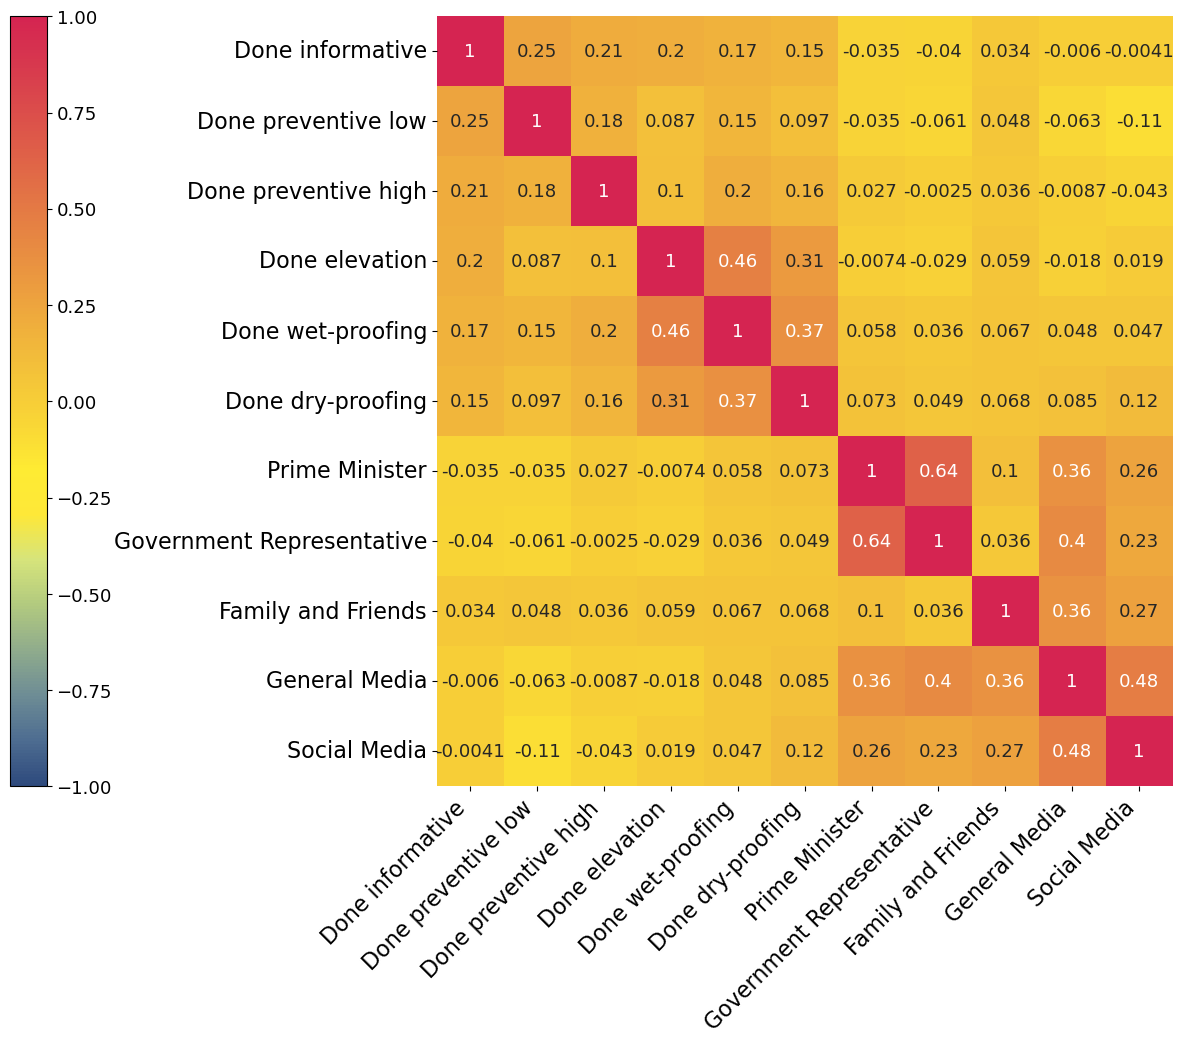

In [13]:
spearman_correlation_matrix(survey_data, meas_done, trust_variables, 'Taken measures spearman correlation')

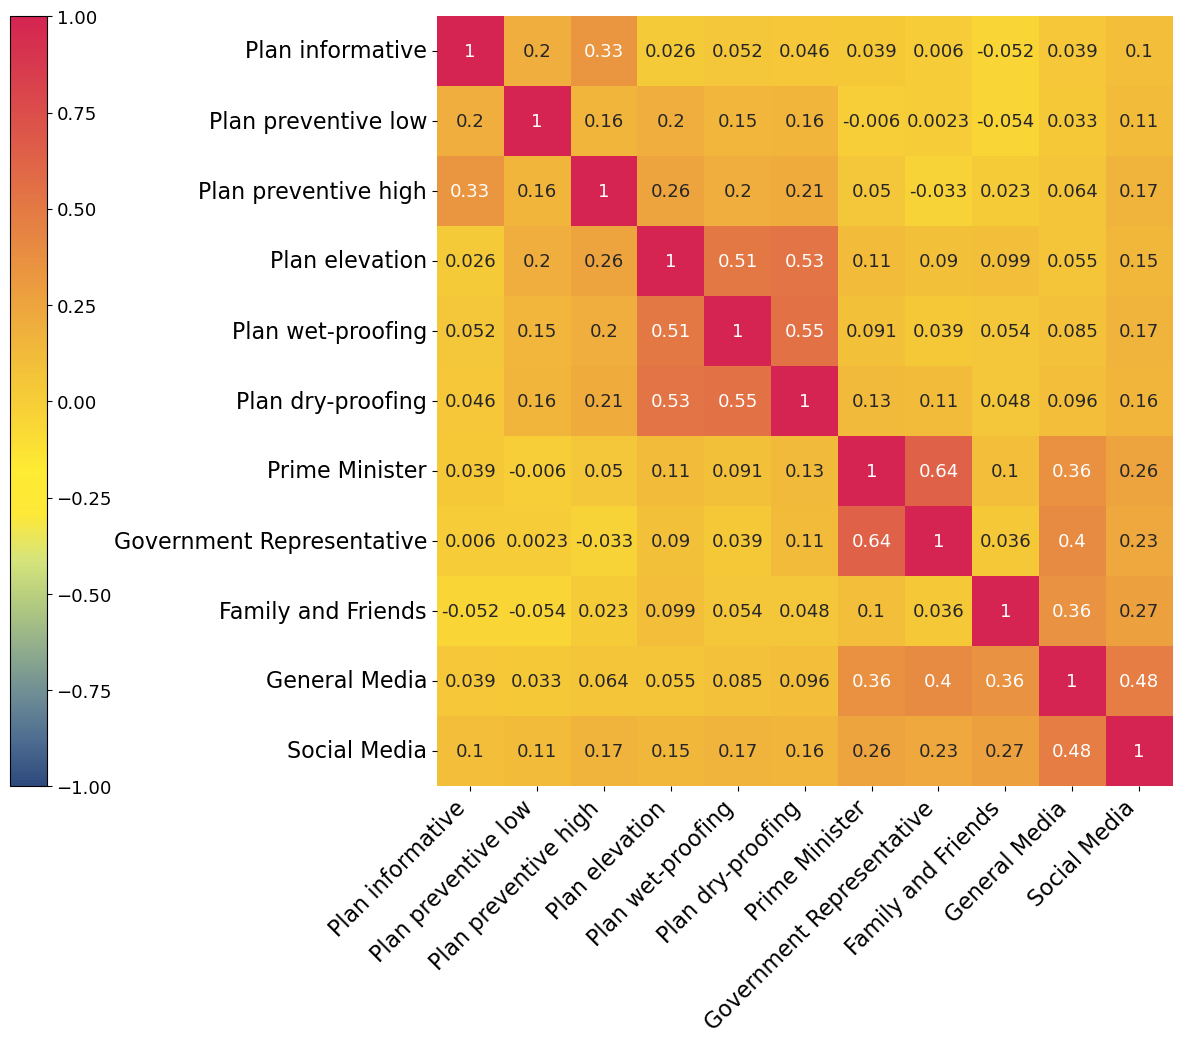

In [14]:
spearman_correlation_matrix(survey_data, meas_plan, trust_variables, 'Planned measures spearman correlation')

# 2. Binary Logistic regression


###  2.1 Grouping and selecting variables
Before the logistic regression takes place, the variables have to be selected. The selection includes the trust variables and PMT variables as mentioned in Chapter 4 of the thesis. I define the variables that are needed into four categories. The variable list to_delete are PMT variables that are grouped later on in this section and therefore the individual variables need to be deleted. To_Keep are variables that do not need to be grouped hence are kept the same. The trust variables also need to be included in the logistic regression, followed by all the measures. 

In [15]:
#These are the variables that are grouped further on in the analysis and therefore are deleted after the grouping takes place. 
to_delete=['R03_perc_damage_UK1', 'R03_perc_damage_UK2', 'R03_perc_damage_UK3', 
                     'R1a_self_efficacy_SM1','R1a_self_efficacy_SM2', 'R1a_self_efficacy_SM3', 'R1a_self_efficacy_SM4', 'R1a_self_efficacy_SM5', 'R1a_self_efficacy_SM6', 'R1a_self_efficacy_SM7',  
                    'R1a_self_efficacy_NM1', 'R1a_self_efficacy_NM2', 'R1a_self_efficacy_NM3','R1a_self_efficacy_NM4','R1a_self_efficacy_NM5','R1a_self_efficacy_NM6','R1a_self_efficacy_NM7','R1a_self_efficacy_NM8',
                    'R1a_self_efficacy_NM9','R1a_self_efficacy_NM10', 'R1a_self_efficacy_NM11',                   
                    'R1b_resp_efficacy_SM1', 'R1b_resp_efficacy_SM2', 'R1b_resp_efficacy_SM3', 'R1b_resp_efficacy_SM4', 'R1b_resp_efficacy_SM5', 'R1b_resp_efficacy_SM6', 'R1b_resp_efficacy_SM7', 
                    'R1b_resp_efficacy_NM1', 'R1b_resp_efficacy_NM2', 'R1b_resp_efficacy_NM3', 'R1b_resp_efficacy_NM4', 'R1b_resp_efficacy_NM5', 'R1b_resp_efficacy_NM6', 'R1b_resp_efficacy_NM7', 
                    'R1b_resp_efficacy_NM8', 'R1b_resp_efficacy_NM9', 'R1b_resp_efficacy_NM10', 'R1b_resp_efficacy_NM11',
                    'R1c_perc_cost_SM1','R1c_perc_cost_SM2', 'R1c_perc_cost_SM3', 'R1c_perc_cost_SM4', 'R1c_perc_cost_SM5', 'R1c_perc_cost_SM6', 'R1c_perc_cost_SM7', 
                    'R1c_perc_cost_NM1','R1c_perc_cost_NM2', 'R1c_perc_cost_NM3', 'R1c_perc_cost_NM4', 'R1c_perc_cost_NM5', 'R1c_perc_cost_NM6', 'R1c_perc_cost_NM7', 
                    'R1c_perc_cost_NM8','R1c_perc_cost_NM9', 'R1c_perc_cost_NM10', 'R1c_perc_cost_NM11']

In [16]:
#The variables that are kept 
to_keep=['Perceived Flood Probability', 'Worry Flood', 'Flood Experience']

In [17]:
#All the variables for the logistic regression
logistic_variables= to_delete + to_keep + trust_variables + all_measures 

Furthermore, some variables need to be transformed into numeric as otherwise they can't be used in the regression. These variables were already spotted as non-numeric in the Step0Exploratory notebook. 

In [18]:
#These variables need to be transformed 
variables_need_transform=['R03_perc_damage_UK1', 'R03_perc_damage_UK2', 'R03_perc_damage_UK3']

In [19]:
#Tranforming the variables
column_numeric(variables_need_transform)

Now the variables are grouped before the logistic regression takes place. 

In [20]:
#Creating a dataframe with the appropiate logistic regression variabels
logistic_survey_data=survey_data[logistic_variables]

In [21]:
#Grouping the three physical damage columns
logistic_survey_data['Perceived Physical Damage'] = logistic_survey_data.R03_perc_damage_UK1.fillna(0) + logistic_survey_data.R03_perc_damage_UK2.fillna(0)+ logistic_survey_data.R03_perc_damage_UK3.fillna(0)

In [22]:
#Grouping efficacy columns according to the group measures
logistic_survey_data['Informative Self Efficacy'] = logistic_survey_data[['R1a_self_efficacy_NM4', 'R1a_self_efficacy_NM5', 'R1a_self_efficacy_NM8', 'R1a_self_efficacy_NM9']].median(axis=1)
logistic_survey_data['Preventive-low Self Efficacy'] = logistic_survey_data[['R1a_self_efficacy_NM1', 'R1a_self_efficacy_NM7', 'R1a_self_efficacy_NM10', 'R1a_self_efficacy_NM11']].median(axis=1)
logistic_survey_data['Preventive-high Self Efficacy'] = logistic_survey_data[['R1a_self_efficacy_NM2', 'R1a_self_efficacy_NM3', 'R1a_self_efficacy_NM6']].median(axis=1)
logistic_survey_data['Elevation Self Efficacy'] = logistic_survey_data[['R1a_self_efficacy_SM1']].median(axis=1)
logistic_survey_data['Wet-proofing Self Efficacy'] = logistic_survey_data[['R1a_self_efficacy_SM2', 'R1a_self_efficacy_SM3', 'R1a_self_efficacy_SM4']].median(axis=1)
logistic_survey_data['Dry-proofing Self Efficacy'] = logistic_survey_data[['R1a_self_efficacy_SM5', 'R1a_self_efficacy_SM6', 'R1a_self_efficacy_SM7']].median(axis=1)

In [23]:
# Respective efficacy columns grouped according to the predefined group measures
logistic_survey_data['Informative Respective Efficacy'] = logistic_survey_data[['R1b_resp_efficacy_NM4', 'R1b_resp_efficacy_NM5', 'R1b_resp_efficacy_NM8', 'R1b_resp_efficacy_NM9']].median(axis=1)
logistic_survey_data['Preventive-low Respective Efficacy'] = logistic_survey_data[['R1b_resp_efficacy_NM1', 'R1b_resp_efficacy_NM7', 'R1b_resp_efficacy_NM10', 'R1b_resp_efficacy_NM11']].median(axis=1)
logistic_survey_data['Preventive-high Respective Efficacy'] = logistic_survey_data[['R1b_resp_efficacy_NM2', 'R1b_resp_efficacy_NM3', 'R1b_resp_efficacy_NM6']].median(axis=1)
logistic_survey_data['Elevation Respective Efficacy'] = logistic_survey_data[['R1b_resp_efficacy_SM1']].median(axis=1)
logistic_survey_data['Wet-proofing Respective Efficacy'] = logistic_survey_data[['R1b_resp_efficacy_SM2', 'R1b_resp_efficacy_SM3', 'R1b_resp_efficacy_SM4']].median(axis=1)
logistic_survey_data['Dry-proofing Respective Efficacy'] = logistic_survey_data[['R1b_resp_efficacy_SM5', 'R1b_resp_efficacy_SM6', 'R1b_resp_efficacy_SM7']].median(axis=1)


In [24]:
# Perceived cost columns grouped according to the predefined group measures
logistic_survey_data['Informative Perceived cost'] = logistic_survey_data[['R1c_perc_cost_NM4', 'R1c_perc_cost_NM5', 'R1c_perc_cost_NM8', 'R1c_perc_cost_NM9']].median(axis=1)
logistic_survey_data['Preventive-low Perceived cost'] = logistic_survey_data[['R1c_perc_cost_NM1', 'R1c_perc_cost_NM7', 'R1c_perc_cost_NM10', 'R1c_perc_cost_NM11']].median(axis=1)
logistic_survey_data['Preventive-high Perceived cost'] = logistic_survey_data[['R1c_perc_cost_NM2', 'R1c_perc_cost_NM3', 'R1c_perc_cost_NM6']].median(axis=1)
logistic_survey_data['Elevation Perceived cost'] = logistic_survey_data[['R1c_perc_cost_SM1']].median(axis=1)
logistic_survey_data['Wet-proofing Perceived cost'] = logistic_survey_data[['R1c_perc_cost_SM2', 'R1c_perc_cost_SM3', 'R1c_perc_cost_SM4']].median(axis=1)
logistic_survey_data['Dry-proofing Perceived cost'] = logistic_survey_data[['R1c_perc_cost_SM5', 'R1c_perc_cost_SM6', 'R1c_perc_cost_SM7']].median(axis=1)

In [25]:
#replacing empty strings with nan values
logistic_survey_data = logistic_survey_data.replace(r'^\s*$', np.nan, regex=True)

In [26]:
#This is the what the dataframe now looks like
logistic_survey_data.head()

,R03_perc_damage_UK1,R03_perc_damage_UK2,R03_perc_damage_UK3,R1a_self_efficacy_SM1,R1a_self_efficacy_SM2,R1a_self_efficacy_SM3,R1a_self_efficacy_SM4,R1a_self_efficacy_SM5,R1a_self_efficacy_SM6,R1a_self_efficacy_SM7,...,Preventive-high Respective Efficacy,Elevation Respective Efficacy,Wet-proofing Respective Efficacy,Dry-proofing Respective Efficacy,Informative Perceived cost,Preventive-low Perceived cost,Preventive-high Perceived cost,Elevation Perceived cost,Wet-proofing Perceived cost,Dry-proofing Perceived cost
0,NaN,98.0,NaN,1,1,1,5,4,2,3,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,5.0,3.0
1,NaN,1.0,NaN,1,1,5,1,3,3,4,...,3.0,1.0,1.0,3.0,1.0,1.0,3.0,5.0,5.0,2.0
2,NaN,1.0,NaN,1,1,5,5,5,5,1,...,3.0,5.0,5.0,4.0,2.0,3.0,5.0,5.0,5.0,1.0
3,NaN,1.0,NaN,1,1,1,1,1,1,1,...,5.0,5.0,5.0,5.0,3.0,5.0,1.0,5.0,5.0,5.0
4,NaN,1.0,NaN,1,2,2,2,2,2,4,...,3.0,2.0,2.0,2.0,1.0,1.5,2.0,5.0,5.0,5.0


Still need to clean several columns

In [27]:
# Removing rows with values such as Don't know, other, prefer not to say 
columns_non_valid = trust_variables + [ 'Perceived Flood Probability', 'Worry Flood', 'Perceived Physical Damage']
values_to_exclude = [97,98,99]

In [28]:
#Deleting the whole row if columns_non_valid contained excluding variables as you cannot remove one single value from a dataframe
filter_column = ~(logistic_survey_data[columns_non_valid].isin(values_to_exclude).any(axis=1))
logistic_survey_data_clean = logistic_survey_data[filter_column]

In [29]:
#Dropping the to_delete columns from above
logistic_survey_data_clean = logistic_survey_data_clean.drop(columns = to_delete)

In [30]:
logistic_survey_data_clean.head()

,Perceived Flood Probability,Worry Flood,Flood Experience,Prime Minister,Government Representative,Family and Friends,General Media,Social Media,Done informative,Done preventive low,...,Preventive-high Respective Efficacy,Elevation Respective Efficacy,Wet-proofing Respective Efficacy,Dry-proofing Respective Efficacy,Informative Perceived cost,Preventive-low Perceived cost,Preventive-high Perceived cost,Elevation Perceived cost,Wet-proofing Perceived cost,Dry-proofing Perceived cost
1,2,1,0,1,1,3,3,1,0,1,...,3.0,1.0,1.0,3.0,1.0,1.0,3.0,5.0,5.0,2.0
2,1,1,0,3,3,5,3,2,1,1,...,3.0,5.0,5.0,4.0,2.0,3.0,5.0,5.0,5.0,1.0
3,1,1,0,5,5,5,1,1,1,1,...,5.0,5.0,5.0,5.0,3.0,5.0,1.0,5.0,5.0,5.0
4,2,1,1,2,2,3,1,1,1,1,...,3.0,2.0,2.0,2.0,1.0,1.5,2.0,5.0,5.0,5.0
5,1,1,0,3,4,3,3,2,1,1,...,3.0,2.0,3.0,3.0,1.5,1.0,4.0,5.0,5.0,4.0


## 2.2 Scaling variables
The variables for the logistic regression are scaled for improved model interpretability as the variables contain different values or Likert scales. 


In [31]:
#Defining the predictors besides the trust variables
other_x_variables=['Perceived Flood Probability', 'Worry Flood', 'Flood Experience','Perceived Physical Damage', 'Informative Self Efficacy', 'Preventive-low Self Efficacy',
       'Preventive-high Self Efficacy', 'Elevation Self Efficacy',
       'Wet-proofing Self Efficacy', 'Dry-proofing Self Efficacy',
       'Informative Respective Efficacy', 'Preventive-low Respective Efficacy',
       'Preventive-high Respective Efficacy', 'Elevation Respective Efficacy',
       'Wet-proofing Respective Efficacy', 'Dry-proofing Respective Efficacy',
       'Informative Perceived cost', 'Preventive-low Perceived cost',
       'Preventive-high Perceived cost', 'Elevation Perceived cost',
       'Wet-proofing Perceived cost', 'Dry-proofing Perceived cost']

 

In [32]:
#Defining which columns need to be scaled
columns_to_be_scaled= trust_variables + other_x_variables

In [33]:
# Creating scaler
scaler = MinMaxScaler()
# Normalising the variables
logistic_survey_data_clean[columns_to_be_scaled] = scaler.fit_transform(logistic_survey_data_clean[columns_to_be_scaled])

In [34]:
#This is the final dataframe
logistic_survey_data_clean.head()

,Perceived Flood Probability,Worry Flood,Flood Experience,Prime Minister,Government Representative,Family and Friends,General Media,Social Media,Done informative,Done preventive low,...,Preventive-high Respective Efficacy,Elevation Respective Efficacy,Wet-proofing Respective Efficacy,Dry-proofing Respective Efficacy,Informative Perceived cost,Preventive-low Perceived cost,Preventive-high Perceived cost,Elevation Perceived cost,Wet-proofing Perceived cost,Dry-proofing Perceived cost
1,0.142857,0.0,0.0,0.00,0.00,0.5,0.5,0.00,0,1,...,0.5,0.00,0.00,0.50,0.000,0.000,0.50,1.0,1.0,0.25
2,0.000000,0.0,0.0,0.50,0.50,1.0,0.5,0.25,1,1,...,0.5,1.00,1.00,0.75,0.250,0.500,1.00,1.0,1.0,0.00
3,0.000000,0.0,0.0,1.00,1.00,1.0,0.0,0.00,1,1,...,1.0,1.00,1.00,1.00,0.500,1.000,0.00,1.0,1.0,1.00
4,0.142857,0.0,1.0,0.25,0.25,0.5,0.0,0.00,1,1,...,0.5,0.25,0.25,0.25,0.000,0.125,0.25,1.0,1.0,1.00
5,0.000000,0.0,0.0,0.50,0.75,0.5,0.5,0.25,1,1,...,0.5,0.25,0.50,0.50,0.125,0.000,0.75,1.0,1.0,0.75


###  2.3 The Regression 
In this section, the binary logistic regression takes place after preparing the dataset.

In [35]:
#Setting the predictors x for the regression, which is equal to the columns that needed to be scaled
x = columns_to_be_scaled

In [36]:
binary_y_vars = [ 'Done informative', 'Done preventive low', 'Done preventive high',  'Done elevation', 'Done wet-proofing',  'Done dry-proofing',  'Plan informative', 'Plan preventive low', 'Plan preventive high', 'Plan elevation', 'Plan wet-proofing', 'Plan dry-proofing'  ]

In [37]:
#Setting a dataframe equal to the predictors
x_df= logistic_survey_data_clean[x]

For visualisation of my PMT variables in my thesis, I quickly create a Latex table before the regression

In [38]:
#This is a dataframe of the PMT 
pmt_table=logistic_survey_data_clean[other_x_variables]

In [39]:
# Creating LaTeX rows from column names
rows = '\n'.join([f"{col} \\\\" for col in pmt_table.columns])

# Building LaTeX table
latex_table = r"""
\begin{table}[h!]
\centering
\begin{tabular}{l}
\toprule
\textbf{PMT Variables} \\
\midrule
""" + rows + r"""
\bottomrule
\end{tabular}
\caption{List of PMT Variables for Logistic Regression}
\label{tab:column-names}
\end{table}
"""

print(latex_table)


\begin{table}[h!]
\centering
\begin{tabular}{l}
\toprule
\textbf{PMT Variables} \\
\midrule
Perceived Flood Probability \\
Worry Flood \\
Flood Experience \\
Perceived Physical Damage \\
Informative Self Efficacy \\
Preventive-low Self Efficacy \\
Preventive-high Self Efficacy \\
Elevation Self Efficacy \\
Wet-proofing Self Efficacy \\
Dry-proofing Self Efficacy \\
Informative Respective Efficacy \\
Preventive-low Respective Efficacy \\
Preventive-high Respective Efficacy \\
Elevation Respective Efficacy \\
Wet-proofing Respective Efficacy \\
Dry-proofing Respective Efficacy \\
Informative Perceived cost \\
Preventive-low Perceived cost \\
Preventive-high Perceived cost \\
Elevation Perceived cost \\
Wet-proofing Perceived cost \\
Dry-proofing Perceived cost \\
\bottomrule
\end{tabular}
\caption{List of PMT Variables for Logistic Regression}
\label{tab:column-names}
\end{table}



Now we can start with the logistic regression. I have not created functions for the regression itself, as I only perform this once (twelve regressions). 

In [40]:
#Adds an intercept to x variables before regression model as statsmodels does not automatically
#include a constant term
x_df = sm.add_constant(x_df)       

#Creating new lists for the results and the model performance
results_list = []
model_performance = []

#For each y variable (measure) the regression is performed
for y_var in binary_y_vars:
    
    # Fitting the model
    y = logistic_survey_data_clean[y_var]
    
    model = sm.Logit(y, x_df)
    result = model.fit(disp=0)

    #Setting the results to values
    for x_var in ['const'] + trust_variables:
        coef = result.params[x_var]
        pval = result.pvalues[x_var]
        odds = np.exp(coef)
        conf_int = result.conf_int().loc[x_var]
        conf_low = np.exp(conf_int[0])
        conf_high = np.exp(conf_int[1])

        #Appending the results in a list
        results_list.append({
            'y variable': y_var,
            'x variable': x_var,
            'coef': coef,
            'odds ratio': odds,
            'conf low': conf_low,
            'conf high': conf_high,
            'p value': pval,
            'pseudo r2': result.prsquared,
            'n obs': int(result.nobs),
            'aic': result.aic 
            
        })
    #Appending the model performance for all twelve regressions at once, 
    #Not in the loop
    model_performance.append({
        'y variable': y_var,
        'pseudo r2': result.prsquared,
        'n obs': int(result.nobs),
        'aic': result.aic})
    
# Creating dataframes out of the list
summary_df = pd.DataFrame(results_list)
model_df = pd.DataFrame(model_performance)

I also want to print the model performance metrics to a table for my thesis. 

In [41]:
#Printing model performance to LaTeX table for in the thesis
print(model_df.to_latex(index=False, float_format=lambda x: f"{x:.2f}".rstrip('0').rstrip('.')))

\begin{tabular}{lrrr}
\toprule
y variable & pseudo r2 & n obs & aic \\
\midrule
Done informative & 0.14 & 483 & 527.07 \\
Done preventive low & 0.1 & 483 & 593.58 \\
Done preventive high & 0.13 & 483 & 326.77 \\
Done elevation & 0.66 & 483 & 96.9 \\
Done wet-proofing & 0.16 & 483 & 274.93 \\
Done dry-proofing & 0.46 & 483 & 142.39 \\
Plan informative & 0.11 & 483 & 465.96 \\
Plan preventive low & 0.19 & 483 & 353.43 \\
Plan preventive high & 0.24 & 483 & 330.9 \\
Plan elevation & 0.66 & 483 & 98.94 \\
Plan wet-proofing & 0.52 & 483 & 135.95 \\
Plan dry-proofing & 0.52 & 483 & 147.4 \\
\bottomrule
\end{tabular}



Next, I have plotted the confidence intervals for the twelve regressions.

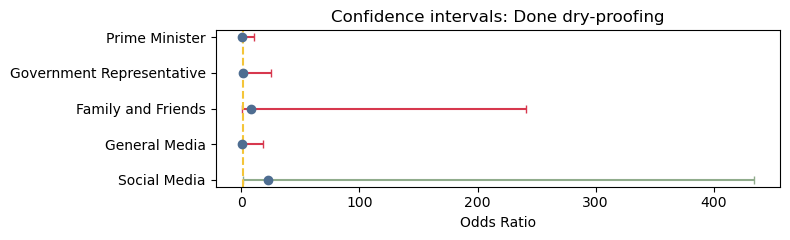

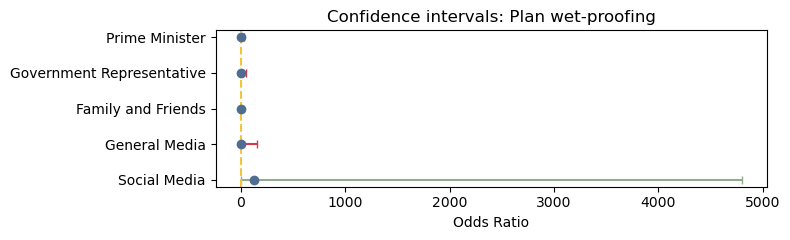

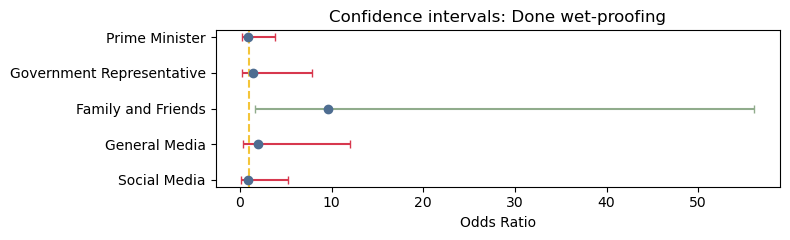

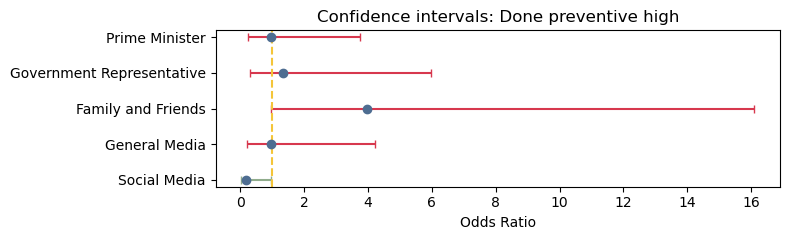

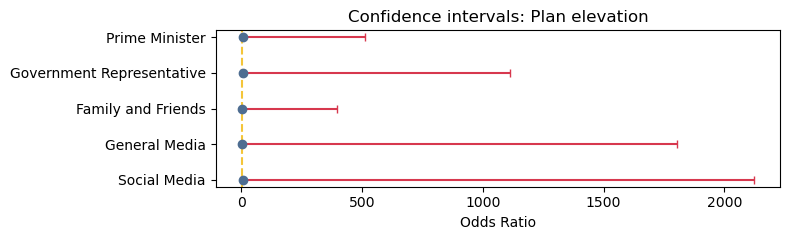

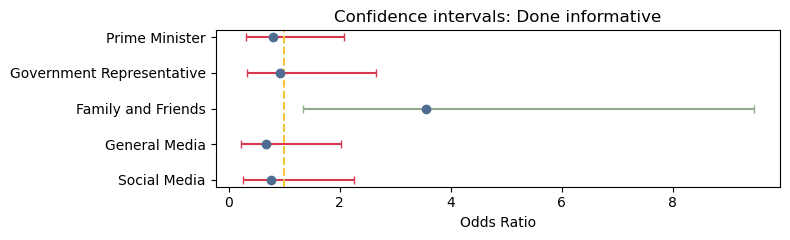

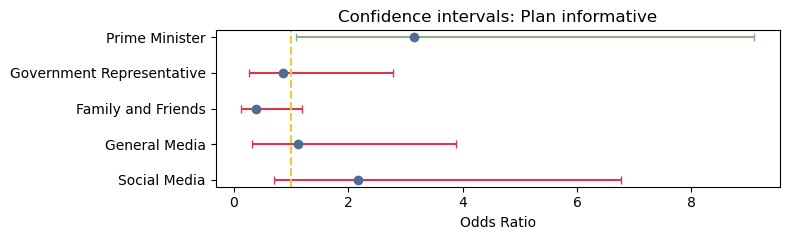

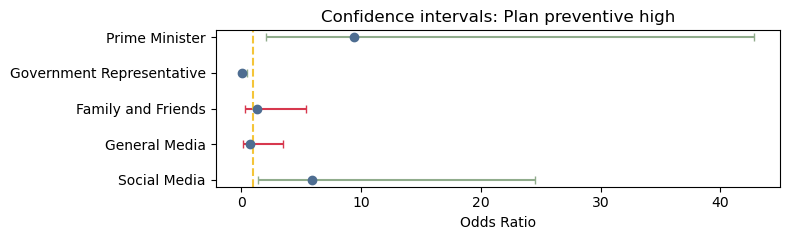

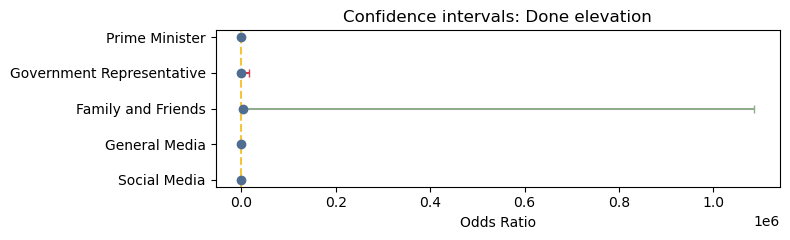

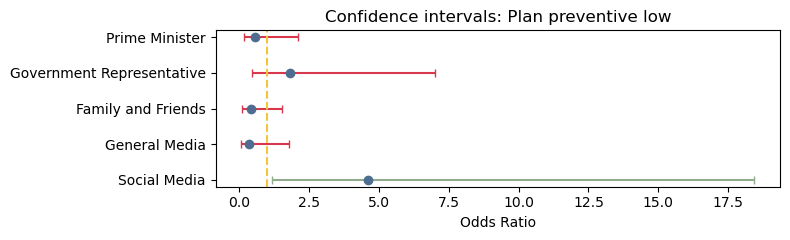

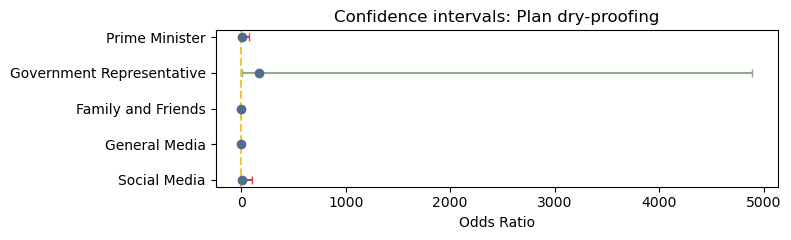

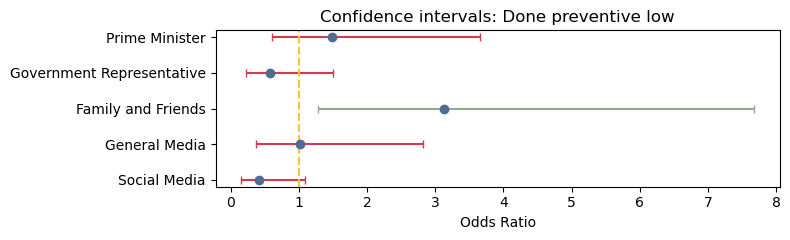

In [42]:
# Getting unique y variables
y_vars = list(set(r['y variable'] for r in results_list))

#Loop through the y variables
for y in y_vars:
    
    # Filtering the results for y variables, not selecting the constants
    filtered = [r for r in results_list if r['y variable'] == y and r['x variable'] != 'const']

    #Selecting the variables, odds ratio, confidence intervals for each y
    variables = [r['x variable'] for r in filtered]
    odds_ratios = [r['odds ratio'] for r in filtered]
    conf_low = [r['conf low'] for r in filtered]
    conf_high = [r['conf high'] for r in filtered]

    #Creating the interval bars based on odds ratio, on its confidence low and confidence high
    error_lower = [or_ - low for or_, low in zip(odds_ratios, conf_low)]
    error_upper = [high - or_ for or_, high in zip(odds_ratios, conf_high)]
    error = [error_lower, error_upper]

    #Plotting the figure
    plt.figure(figsize=(8, len(variables)*0.5))
    #Plots the error bar

    for i, (or_, low, high, el, eu) in enumerate(zip(odds_ratios, conf_low, conf_high, error_lower, error_upper)):
        if high < 1 or low > 1:
            marker_color = '#4e6d91'
            errorbar_color = '#90ac8c'
        else:
            marker_color = '#4e6d91'
            errorbar_color = '#d7384e'

        # plt.errorbar(odds_ratios, range(len(variables)), xerr=error, fmt='o', color=marker_color, ecolor=errorbar_color, capsize=3)
        plt.errorbar(
        x=or_, y=i,
        xerr=[[el], [eu]],  # Asymmetric x-error
        fmt='o',
        color=marker_color,   # Dot color
        ecolor=errorbar_color,  # Error bar color
        capsize=3
    )

    
    plt.yticks(range(len(variables)), variables)
    #Sets the line at 1, tipping point for odds ratio
    plt.axvline(x=1, color='#f4c539', linestyle='--')
    plt.xlabel('Odds Ratio')
    plt.title(f'Confidence intervals: {y}')

    #The following inverts the y-axis, so that the prime minister variable is shown first
    plt.gca().invert_yaxis()
    plt.tight_layout()

    #Creating a file path and saving the figure for my thesis
    full_path = os.path.join('../figures/step2/confidence', y)
    plt.savefig(full_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.show()

To display the binary logistic regression results properly, I have created heatmaps for each metric.

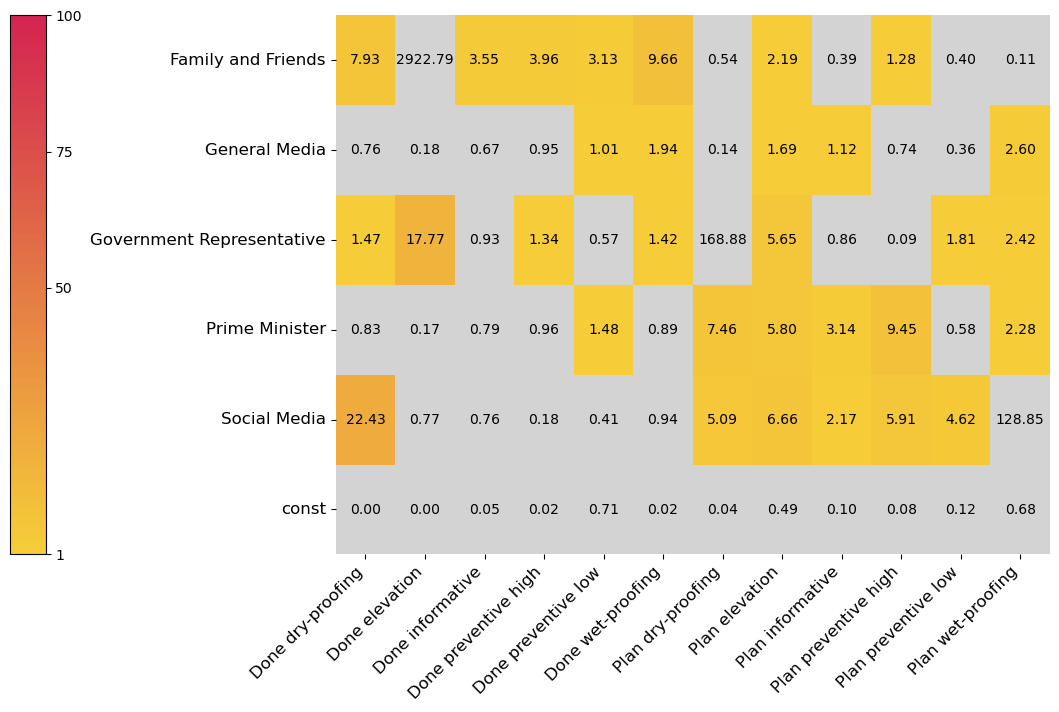

In [43]:
#Heatmap of the odds ratio
heatmap_regression('odds ratio', 'Trust heatmap of odds ratio logistic regression', summary_df, 1, 100, 1, 100)

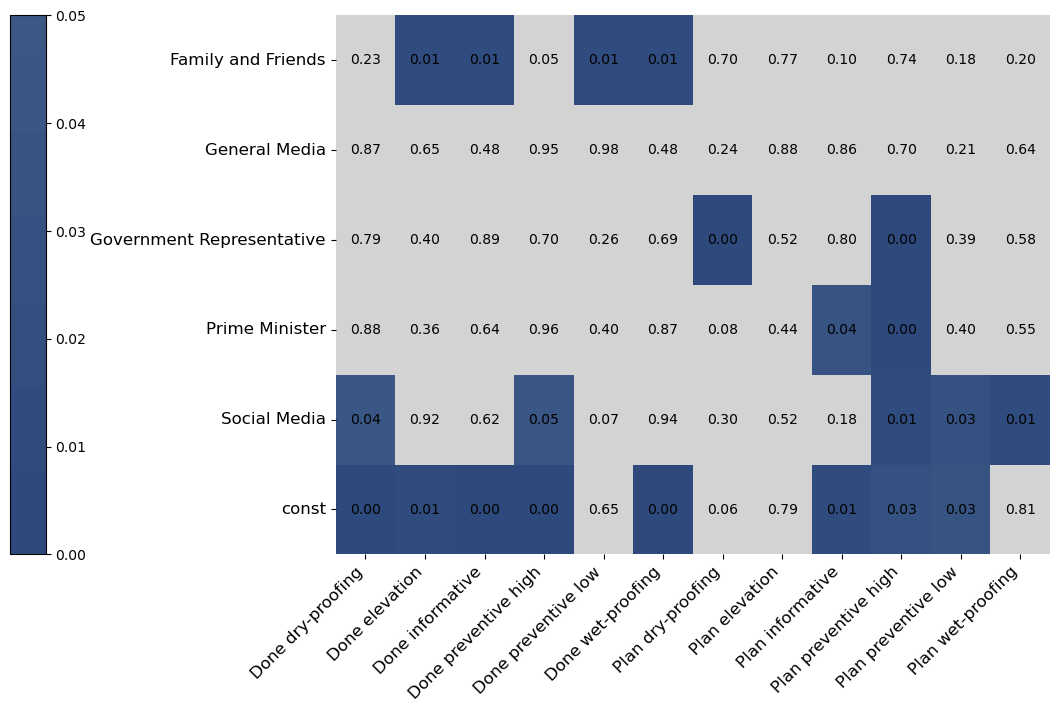

In [44]:
#Heatmap of the p-value
heatmap_regression('p value', 'Trust heatmap of p value logistic regression', summary_df,  0, 0.05, 0, 0.05)